In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82480 entries, 0 to 82479
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              82480 non-null  float64
 1   distance_from_last_transaction  82480 non-null  float64
 2   ratio_to_median_purchase_price  82480 non-null  float64
 3   repeat_retailer                 82479 non-null  float64
 4   used_chip                       82479 non-null  float64
 5   used_pin_number                 82479 non-null  float64
 6   online_order                    82479 non-null  float64
 7   fraud                           82479 non-null  float64
dtypes: float64(8)
memory usage: 5.0 MB


In [ ]:
#check null values
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   1
used_chip                         1
used_pin_number                   1
online_order                      1
fraud                             1
dtype: int64

In [ ]:
df.repeat_retailer.replace([np.nan], df.repeat_retailer.mode(), inplace=True);
df.used_chip .replace([np.nan], df.used_chip .mode(), inplace=True);
df.used_pin_number .replace([np.nan], df.used_pin_number .mode(), inplace=True);
df.online_order .replace([np.nan], df.online_order .mode(), inplace=True);
df.fraud .replace([np.nan], df.fraud .mode(), inplace=True);

In [ ]:
any(df.isna().sum() > 0)

False

In [ ]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,82480.000000,82480.000000,82480.000000,82480.000000,82480.000000,82480.000000,82480.000000,82480.000000
mean,26.713061,5.075029,1.810650,0.883172,0.351285,0.102679,0.651370,0.086445
std,65.323266,25.111760,2.798818,0.321218,0.477375,0.303542,0.476539,0.281022
min,0.021322,0.000488,0.011373,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.883500,0.295361,0.475359,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.974480,0.991814,0.994048,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.780192,3.337982,2.078892,1.000000,1.000000,0.000000,1.000000,0.000000
max,4601.011222,2160.499922,126.294930,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cat_feats = [x for x in df.columns if len(df[x].unique()) <=2]
num_feats = [x for x in df.columns if x not in cat_feats]

In [ ]:
df['fraud'].value_counts()

0.0    75350
1.0     7130
Name: fraud, dtype: int64

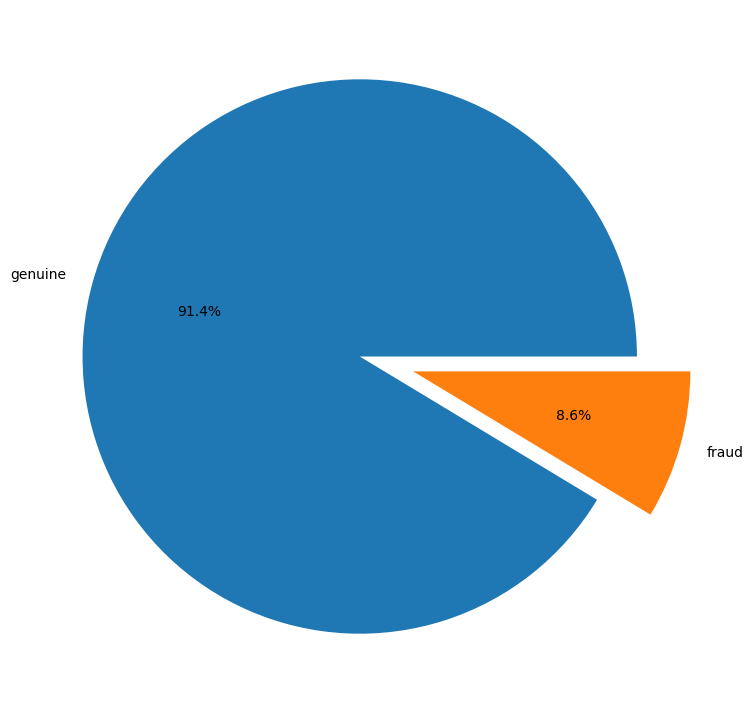

In [ ]:
vc = df['fraud'].value_counts(ascending=False)

plt.pie(x=vc.values, labels=['genuine','fraud'], explode=[0.0, 0.2], autopct='%1.1f%%')
plt.show()

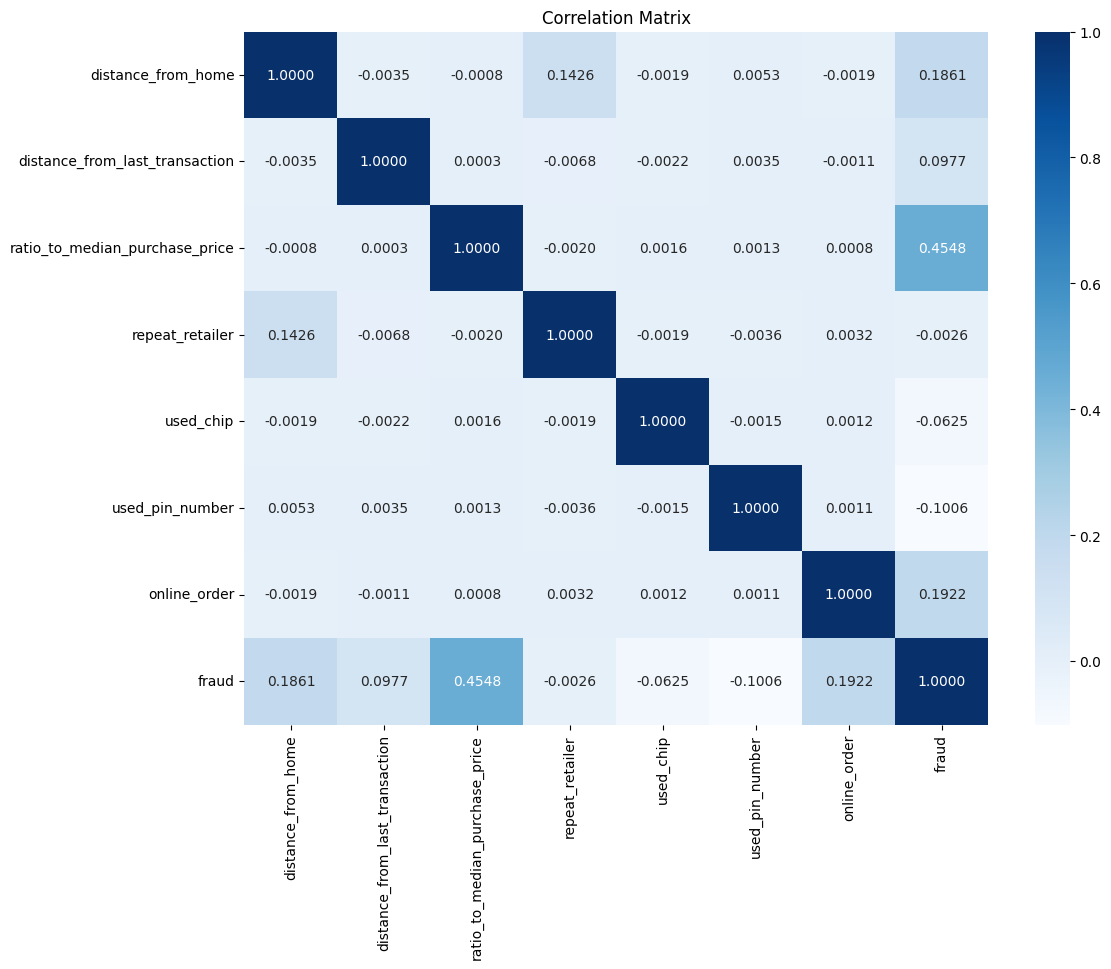

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#Most correlation values are very close to 0, which indicates that our features are weakly correlated
#PCA assumes linearity in the data, and it does not work well with Non-linear features
#This is where Autoencoders prove to be useful, since they can capture the complex relationships in the data

In [1]:
sns.displot(data=df, x='distance_from_home', hue='fraud', log_scale=True, kde=True)
plt.show()

NameError: ignored

In [ ]:
#feature scaling
ct = make_column_transformer(
    (StandardScaler(), num_feats)
)

df_scaled = pd.DataFrame(ct.fit_transform(df), columns=num_feats)
df_cat_feats = df[cat_feats]

df_concat = pd.concat([df_scaled, df_cat_feats], axis=1)
df_concat.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.477089,-0.189709,0.048338,1.0,1.0,0.0,0.0,0.0
1,-0.243148,-0.195106,-0.184519,1.0,0.0,0.0,0.0,0.0
2,-0.331002,-0.170036,-0.494117,1.0,0.0,0.0,1.0,0.0
3,-0.374532,0.020907,-0.517360,1.0,1.0,0.0,1.0,0.0
4,0.267561,-0.179540,0.147248,1.0,1.0,0.0,1.0,0.0


In [ ]:
#genuine data
X = df_concat.drop(['fraud'], axis=1)
y = df_concat['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_genuine = X_train[~y_train]
X_test_genuine = X_test[~y_test]

X_train_fraud = X_train[y_train]
X_test_fraud = X_test[y_test]

In [ ]:
CODE_DIM = 2
INPUT_SHAPE = X_train.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

autoencoder = Model(input_layer, output_layer, name='anomaly')

In [ ]:
model_name = "anomaly.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [ ]:
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [ ]:
history = autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=35, batch_size=32,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks, shuffle=True)

Epoch 1/35
1759/1765 [============================>.] - ETA: 0s - loss: 0.2780
Epoch 1: val_loss improved from inf to 0.29799, saving model to anomaly.h5
1765/1765 [==============================] - 8s 4ms/step - loss: 0.2781 - val_loss: 0.2980
Epoch 2/35
1759/1765 [============================>.] - ETA: 0s - loss: 0.2707
Epoch 2: val_loss did not improve from 0.29799
1765/1765 [==============================] - 5s 3ms/step - loss: 0.2707 - val_loss: 0.2980
Epoch 3/35
1760/1765 [============================>.] - ETA: 0s - loss: 0.2705
Epoch 3: val_loss improved from 0.29799 to 0.29794, saving model to anomaly.h5
1765/1765 [==============================] - 5s 3ms/step - loss: 0.2705 - val_loss: 0.2979
Epoch 4/35
1764/1765 [============================>.] - ETA: 0s - loss: 0.2705
Epoch 4: val_loss improved from 0.29794 to 0.29762, saving model to anomaly.h5
1765/1765 [==============================] - 8s 4ms/step - loss: 0.2705 - val_loss: 0.2976
Epoch 5/35
1746/1765 [==================

In [ ]:
reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)

In [ ]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.129412,False
1,0.118721,False
2,0.272948,False
3,0.124051,False
4,0.149580,False


In [ ]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 10)

Threshold: 0.0139	Accuracy: 0.084		Precision: 0.542	Recall Score: 0.500
Threshold: 0.1065	Accuracy: 0.184		Precision: 0.546	Recall Score: 0.555
Threshold: 0.1441	Accuracy: 0.284		Precision: 0.552	Recall Score: 0.609
Threshold: 0.2089	Accuracy: 0.383		Precision: 0.559	Recall Score: 0.662
Threshold: 0.2355	Accuracy: 0.483		Precision: 0.569	Recall Score: 0.715
Threshold: 0.2543	Accuracy: 0.582		Precision: 0.582	Recall Score: 0.769
Threshold: 0.2726	Accuracy: 0.682		Precision: 0.603	Recall Score: 0.821
Threshold: 0.2923	Accuracy: 0.781		Precision: 0.636	Recall Score: 0.872
Threshold: 0.3431	Accuracy: 0.864		Precision: 0.679	Recall Score: 0.873
Threshold: 0.4362	Accuracy: 0.916		Precision: 0.730	Recall Score: 0.770


In [ ]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.343103


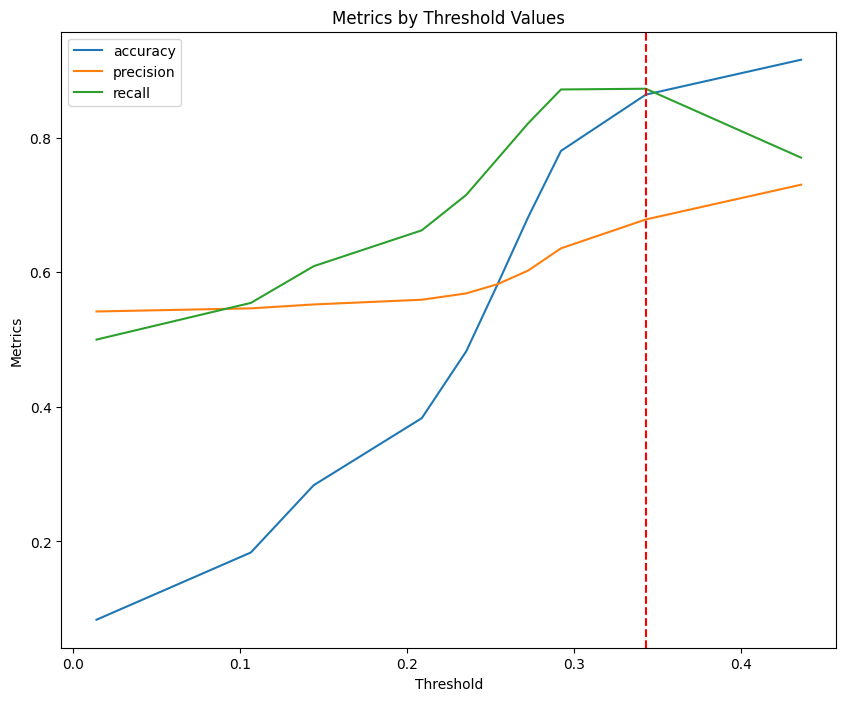

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

In [ ]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,0.129412,False,False
1,0.118721,False,False
2,0.272948,False,False
3,0.124051,False,False
4,0.149580,False,False


In [ ]:
print(classification_report(recons_df['y_true'],recons_df['y_pred']))

              precision    recall  f1-score   support

       False       0.99      0.86      0.92     18896
        True       0.37      0.88      0.52      1724

    accuracy                           0.86     20620
   macro avg       0.68      0.87      0.72     20620
weighted avg       0.94      0.86      0.89     20620



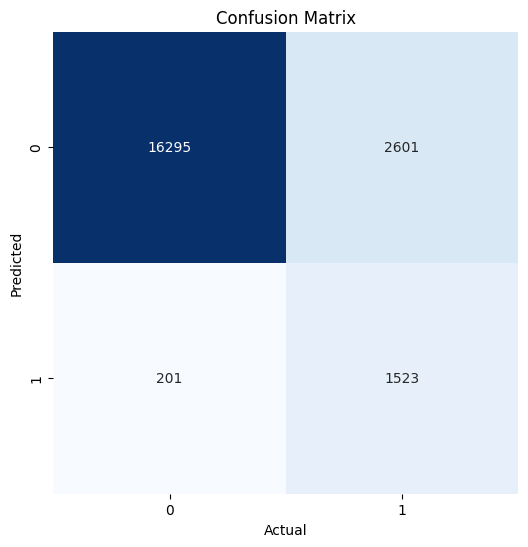

In [ ]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")

Recall Score: 88.341%
Accuracy Score: 86.411%
